# About On-Time in FACT

Recently questions were raised about how to retrieve the on-time, i.e. the time of a certain run, where the camera was actually "trigger-ready". This little document tries to answer a few of them.

## Introduction to on-time measurement

The FACT Trigger Master board (FTM) is responsible for book keeping of the on-time. It does this by running two 48 bit counters at a frquency of 1MHz.
The ontime counter is counting up only when the camera is "trigger-ready", and is stopped in case no trigger can be accepted. Reasons for rejecting incoming triggers are:

 * trigger is disabled
 * a trigger was just sent to the FADs and read-out is in progress (fixed dead time)
 * the FADs claim to be (still) busy with reading out
 * the FAD onboard memory is full (need to wait for daq PC to read out events)
 
The other counter is just always counting up.
Both counters are reset when a run is started.

So the ontime counter is started exactly when the trigger becomes activated and stopped as soon as the trigger is deactivated at the end of a run. After deactivating the trigger, the ontime counter value is frozen and can be read out. Then this number is written into the header of the raw-data file, since it is needed to interpret the events stored in this file. 

However this is not how we do it in FACT.


## The way we do it in FACT++ using DYNAMIC_DATA

The FACT++ program `ftmctrl` continuously (every 5 seconds) reads out the FTM status. The answer contains apart from other interesting data, the current values of the aforementioned counters. These are written to an auxiliary file as part of the dim service named "FTM_CONTROL/DYNAMIC_DATA". 

From this raw-ish data directly read form the board one can already calculate or rather get the best estimate of the ontime, all we need is the stoptime of the run, which we'll retrieve from the "RunInfo" table from the "factdata" MySQL database.

Follow along:

First we'll open the aux-file, readout the binary table contents and drop those columns we are not really interested in.

In [1]:
from astropy.table import Table

path = '/home/dneise/fact/data/aux/20161204.FTM_CONTROL_DYNAMIC_DATA.fits'
table = Table.read(path)
table.remove_columns([
    'TriggerPatchCounter',
    'BoardsCounter',
    'RateOverflow',
    'Prescaling',
    'Temperatures',
    'CrcError',
    'QoS',
    'State'
])

These warnings? Ah ... you can ignore them, they simply mean we are not using fits files the way the astronomers want us to use them. 

We'll convert this `table`, to a `pandas.DataFrame` and index it by `Time`.

In [2]:
import pandas as pd
frame = table.to_pandas()
frame['Time'] = pd.to_datetime(frame['Time']*24*3600*1e9, unit='ns')
frame.set_index('Time', inplace=True)

We also need the start and stop times of the runs, these can be found inside the raw files, but its more convenient to retrieve these numbers from the "RunInfo" table. 

In [3]:
from fact.credentials import create_factdb_engine
runinfo = pd.read_sql(
    "SELECT * FROM RunInfo WHERE fNight = 20161204", 
    create_factdb_engine())
runinfo['duration'] = runinfo.fRunStop - runinfo.fRunStart
runinfo['run_center_time'] = runinfo.fRunStart + runinfo.duration / 2  # good for plotting

example_run = runinfo.iloc[201]

The next is not needed at all to calculate the ontime, but it might be illustrative, so I though it might be worth your time reading it.

I will simply plot both counter values versus time for our example run number 201.
Since the counter freqency is 1MHz, I can translate the counter values to seconds.

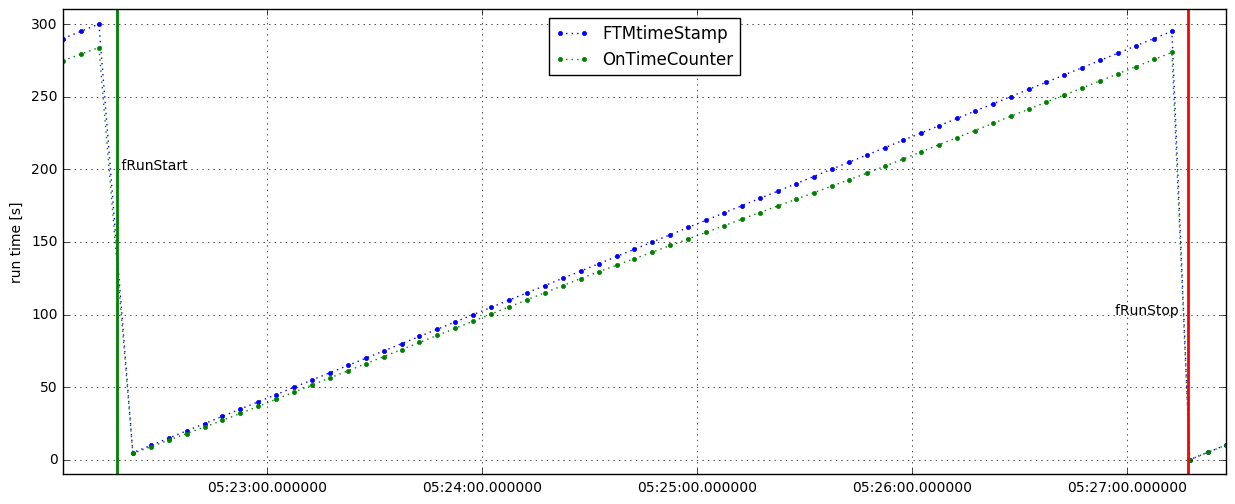

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta  # to include 15sec before and after the run.

part = frame[
    example_run.fRunStart - timedelta(seconds=15):
    example_run.fRunStop + timedelta(seconds=15)
] 

plt.figure(figsize=(15,6))
plt.plot(part.FTMtimeStamp/1e6, 'b.:', label='FTMtimeStamp')
plt.plot(part.OnTimeCounter/1e6, 'g.:', label='OnTimeCounter')
plt.ylim(-10, 310)
plt.ylabel('run time [s]')

plt.axvline(example_run.fRunStart, color='g', linewidth=2)
plt.annotate(s=" fRunStart", xy=(example_run.fRunStart, 200))

plt.axvline(example_run.fRunStop, color='r', linewidth=2)
plt.annotate(s="fRunStop  ", xy=(example_run.fRunStop, 100), horizontalalignment='right')

plt.legend(loc='upper center')
plt.grid()


We can see how both counters are reset at the beginning of the run, there is no data point at the beginning of the run unfortunately to confirm that both counters are zero at that time, but we know it anyway, right?

Obviously both counters are very much in sync at the beginning of the run and as expected the ontime counter counts slower than the realtime counter, since there is some deadtime.

As we can see, there is no value of the ontime counter at the time of the end of the run we could use to get the ontime. However we have another way. By calculating the **relative ontime** from the ontime counter values we have, and multiplying these with the runtime, i.e. the time between the vertical lines, we can recover the missing ontime very reliably.

So let's to it. All we need is the last entry before the end of the run.

In [5]:
last_entry = frame[:example_run.fRunStop].iloc[-1]
too_short_ontime_in_sec = last_entry.OnTimeCounter / 1e6

print("too_short_ontime_in_sec", too_short_ontime_in_sec)

too_short_ontime_in_sec 280.443649


In [6]:
too_short_realtime_in_sec = last_entry.FTMtimeStamp / 1e6
print("too_short_realtime_in_sec", too_short_realtime_in_sec)

too_short_realtime_in_sec 294.986551


In [7]:
correct_relative_ontime = too_short_ontime_in_sec / too_short_realtime_in_sec
print("best estimate for relative ontime {:0.1f} %".format(correct_relative_ontime * 100))

best estimate for relative ontime 95.1 %


In [8]:
runtime = (example_run.fRunStop - example_run.fRunStart).total_seconds()
print("duration: {:0.2f} seconds".format(runtime))
print("best estimate for ontime: {:0.2f} seconds".format(runtime * correct_relative_ontime))

duration: 299.00 seconds
best estimate for ontime: 284.26 seconds
